In [1]:
# Author: Marco Lugo
# Simple localization model, direct bounding box regression using convolutional neural networks
# Using stochastic gradient descent with momentum and decay

import numpy as np

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.models import load_model

from utils import datasets

nb_epochs = 1000

Using TensorFlow backend.


In [2]:
X_train, Y_train_masks, Y_train_classes, X_val, Y_val_masks, Y_val_classes, Y_train_bbox, Y_val_bbox = datasets.load_data()

print(X_train.shape)
print(Y_train_bbox.shape)

print(X_val.shape)
print(Y_val_bbox.shape)

(1463, 128, 128, 3)
(1463, 4)
(337, 128, 128, 3)
(337, 4)


In [3]:
# Dropped augmentation here as Keras has no support for bounding box augmentation. 
#It could be implemented with a different generator.

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, Y_train_bbox)
validation_generator = test_datagen.flow(X_val, Y_val_bbox)

In [4]:
def build_model(img_size=128):
    inputs = Input((img_size, img_size, 3))
    x = BatchNormalization()(inputs)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalMaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    outputs = Dense(4)(x) # Activation is f(x) = x

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_model()
model.summary()
opt = SGD(lr=0.001, momentum=0.75, decay=0.001/nb_epochs, nesterov=False)
model.compile(loss='mean_absolute_error', optimizer=opt)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        2320      
__________

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=12, verbose=1)
checkpoint = ModelCheckpoint('loc2_best.h5', monitor='val_loss', save_best_only=True, period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0)
#schedule = LearningRateScheduler()

model.fit_generator(train_generator, validation_data=validation_generator, epochs=nb_epochs,
                        verbose=1, callbacks=[checkpoint])

Epoch 1/1000
46/46 [==============================] - 4s 93ms/step - loss: 45.6181 - val_loss: 45.5112
Epoch 2/1000
46/46 [==============================] - 2s 46ms/step - loss: 45.2582 - val_loss: 45.3982
Epoch 3/1000
46/46 [==============================] - 2s 47ms/step - loss: 44.8974 - val_loss: 43.8435
Epoch 4/1000
46/46 [==============================] - 2s 44ms/step - loss: 44.4881 - val_loss: 45.5276
Epoch 5/1000
46/46 [==============================] - 2s 44ms/step - loss: 44.0967 - val_loss: 44.7386
Epoch 6/1000
46/46 [==============================] - 2s 43ms/step - loss: 43.7826 - val_loss: 46.9001
Epoch 7/1000
46/46 [==============================] - 2s 44ms/step - loss: 43.4490 - val_loss: 47.0879
Epoch 8/1000
46/46 [==============================] - 2s 43ms/step - loss: 43.0502 - val_loss: 44.0219
Epoch 9/1000
46/46 [==============================] - 2s 43ms/step - loss: 42.7486 - val_loss: 44.9511
Epoch 10/1000
46/46 [==============================] - 2s 46ms/step - los

46/46 [==============================] - 2s 44ms/step - loss: 8.9511 - val_loss: 5.2385
Epoch 81/1000
46/46 [==============================] - 2s 45ms/step - loss: 9.3113 - val_loss: 8.1176
Epoch 82/1000
46/46 [==============================] - 2s 44ms/step - loss: 8.9363 - val_loss: 8.1678
Epoch 83/1000
46/46 [==============================] - 2s 44ms/step - loss: 9.3084 - val_loss: 4.8217
Epoch 84/1000
46/46 [==============================] - ETA: 0s - loss: 9.375 - 2s 45ms/step - loss: 9.3836 - val_loss: 13.8131
Epoch 85/1000
46/46 [==============================] - 2s 44ms/step - loss: 8.9951 - val_loss: 5.3520
Epoch 86/1000
46/46 [==============================] - 2s 43ms/step - loss: 9.0986 - val_loss: 7.2514
Epoch 87/1000
46/46 [==============================] - 2s 43ms/step - loss: 9.4504 - val_loss: 6.5462
Epoch 88/1000
46/46 [==============================] - 2s 45ms/step - loss: 9.2200 - val_loss: 10.4278
Epoch 89/1000
46/46 [==============================] - 2s 46ms/step - 

46/46 [==============================] - 2s 45ms/step - loss: 8.0662 - val_loss: 3.3898
Epoch 160/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.9847 - val_loss: 6.0840
Epoch 161/1000
46/46 [==============================] - 2s 46ms/step - loss: 8.2214 - val_loss: 5.3499
Epoch 162/1000
46/46 [==============================] - 2s 46ms/step - loss: 7.8048 - val_loss: 4.0699
Epoch 163/1000
46/46 [==============================] - 2s 46ms/step - loss: 8.0894 - val_loss: 6.3563
Epoch 164/1000
46/46 [==============================] - 2s 47ms/step - loss: 7.7911 - val_loss: 3.3095
Epoch 165/1000
46/46 [==============================] - 2s 47ms/step - loss: 8.1413 - val_loss: 3.9455
Epoch 166/1000
46/46 [==============================] - 2s 47ms/step - loss: 8.0164 - val_loss: 3.4692
Epoch 167/1000
46/46 [==============================] - 2s 46ms/step - loss: 7.8816 - val_loss: 6.2259
Epoch 168/1000
46/46 [==============================] - 2s 45ms/step - loss: 8.3138 - va

46/46 [==============================] - 2s 45ms/step - loss: 7.6179 - val_loss: 2.9535
Epoch 239/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.9595 - val_loss: 3.6157
Epoch 240/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.5510 - val_loss: 3.0186
Epoch 241/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.5066 - val_loss: 3.9065
Epoch 242/1000
46/46 [==============================] - 2s 46ms/step - loss: 7.6510 - val_loss: 3.0527
Epoch 243/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.6743 - val_loss: 3.0214
Epoch 244/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.3603 - val_loss: 3.1501
Epoch 245/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.3167 - val_loss: 3.6367
Epoch 246/1000
46/46 [==============================] - 2s 48ms/step - loss: 7.5420 - val_loss: 3.5457
Epoch 247/1000
46/46 [==============================] - 2s 46ms/step - loss: 7.3585 - va

46/46 [==============================] - 2s 47ms/step - loss: 7.4488 - val_loss: 3.7662
Epoch 318/1000
46/46 [==============================] - 2s 46ms/step - loss: 7.3158 - val_loss: 3.2375
Epoch 319/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.6179 - val_loss: 3.4904
Epoch 320/1000
46/46 [==============================] - 2s 46ms/step - loss: 7.2748 - val_loss: 2.5514
Epoch 321/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.1514 - val_loss: 3.5606
Epoch 322/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.9964 - val_loss: 2.7660
Epoch 323/1000
46/46 [==============================] - 2s 47ms/step - loss: 7.3890 - val_loss: 2.9917
Epoch 324/1000
46/46 [==============================] - 2s 46ms/step - loss: 7.3048 - val_loss: 3.8488
Epoch 325/1000
46/46 [==============================] - 2s 46ms/step - loss: 6.9490 - val_loss: 3.1669
Epoch 326/1000
46/46 [==============================] - 2s 46ms/step - loss: 7.3615 - va

46/46 [==============================] - 2s 45ms/step - loss: 7.0106 - val_loss: 4.0725
Epoch 397/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.0060 - val_loss: 2.8072
Epoch 398/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.0503 - val_loss: 2.6975
Epoch 399/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.6643 - val_loss: 2.7998
Epoch 400/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.2720 - val_loss: 3.9859
Epoch 401/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.9234 - val_loss: 3.6553
Epoch 402/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.0629 - val_loss: 3.3979
Epoch 403/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.1193 - val_loss: 3.1938
Epoch 404/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.9774 - val_loss: 3.6679
Epoch 405/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.4222 - va

46/46 [==============================] - 2s 44ms/step - loss: 6.9684 - val_loss: 3.3405
Epoch 476/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.0508 - val_loss: 3.2007
Epoch 477/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.8732 - val_loss: 2.8250
Epoch 478/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.0508 - val_loss: 2.9328
Epoch 479/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.9107 - val_loss: 2.6264
Epoch 480/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.2361 - val_loss: 3.1841
Epoch 481/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.1071 - val_loss: 3.0315
Epoch 482/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.1097 - val_loss: 2.6513
Epoch 483/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.1260 - val_loss: 3.3988
Epoch 484/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.0880 - va

46/46 [==============================] - 2s 45ms/step - loss: 6.9327 - val_loss: 2.5736
Epoch 555/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.6949 - val_loss: 2.4304
Epoch 556/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.7439 - val_loss: 2.6475
Epoch 557/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.0573 - val_loss: 2.6239
Epoch 558/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.2219 - val_loss: 2.2552
Epoch 559/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.9689 - val_loss: 3.0918
Epoch 560/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.2160 - val_loss: 2.2233
Epoch 561/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.9379 - val_loss: 2.6048
Epoch 562/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.9514 - val_loss: 2.4203
Epoch 563/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.9441 - va

46/46 [==============================] - 2s 44ms/step - loss: 6.6881 - val_loss: 3.1112
Epoch 634/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.7583 - val_loss: 2.8039
Epoch 635/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.1697 - val_loss: 2.6246
Epoch 636/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.9192 - val_loss: 2.7775
Epoch 637/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.6990 - val_loss: 2.3403
Epoch 638/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.0239 - val_loss: 2.8026
Epoch 639/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.8495 - val_loss: 2.6060
Epoch 640/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.0053 - val_loss: 2.2158
Epoch 641/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.9650 - val_loss: 2.8638
Epoch 642/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.5518 - va

46/46 [==============================] - 2s 44ms/step - loss: 7.8945 - val_loss: 4.9586
Epoch 713/1000
46/46 [==============================] - 2s 44ms/step - loss: 8.1383 - val_loss: 4.8019
Epoch 714/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.7561 - val_loss: 4.5146
Epoch 715/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.3165 - val_loss: 3.0456
Epoch 716/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.7423 - val_loss: 3.3550
Epoch 717/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.5467 - val_loss: 3.1703
Epoch 718/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.1817 - val_loss: 3.4454
Epoch 719/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.4649 - val_loss: 4.2757
Epoch 720/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.7220 - val_loss: 3.2400
Epoch 721/1000
46/46 [==============================] - 2s 44ms/step - loss: 7.0379 - va

46/46 [==============================] - 2s 44ms/step - loss: 6.7724 - val_loss: 2.5059
Epoch 792/1000
46/46 [==============================] - 2s 45ms/step - loss: 7.1241 - val_loss: 3.3594
Epoch 793/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.6848 - val_loss: 2.6682
Epoch 794/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.9146 - val_loss: 2.2952
Epoch 795/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.8484 - val_loss: 2.2739
Epoch 796/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.9419 - val_loss: 2.6514
Epoch 797/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.6382 - val_loss: 2.7766
Epoch 798/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.8233 - val_loss: 2.3425
Epoch 799/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.7944 - val_loss: 2.8937
Epoch 800/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.7984 - va

46/46 [==============================] - 2s 45ms/step - loss: 6.6079 - val_loss: 2.4441
Epoch 871/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.3793 - val_loss: 2.9353
Epoch 872/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.7070 - val_loss: 2.2917
Epoch 873/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.6833 - val_loss: 2.6209
Epoch 874/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.5288 - val_loss: 2.3050
Epoch 875/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.6644 - val_loss: 2.5308
Epoch 876/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.6902 - val_loss: 2.5247
Epoch 877/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.2496 - val_loss: 2.5000
Epoch 878/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.7289 - val_loss: 2.5731
Epoch 879/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.5160 - va

46/46 [==============================] - 2s 49ms/step - loss: 7.0087 - val_loss: 2.3907
Epoch 950/1000
46/46 [==============================] - 2s 49ms/step - loss: 6.5590 - val_loss: 2.4512
Epoch 951/1000
46/46 [==============================] - 2s 49ms/step - loss: 6.7541 - val_loss: 2.1943
Epoch 952/1000
46/46 [==============================] - 2s 47ms/step - loss: 6.5904 - val_loss: 2.8913
Epoch 953/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.6903 - val_loss: 2.1795
Epoch 954/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.6062 - val_loss: 2.3674
Epoch 955/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.8309 - val_loss: 2.5003
Epoch 956/1000
46/46 [==============================] - 2s 44ms/step - loss: 6.9073 - val_loss: 2.7693
Epoch 957/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.8274 - val_loss: 2.4710
Epoch 958/1000
46/46 [==============================] - 2s 45ms/step - loss: 6.7178 - va

In [6]:
model = load_model('loc2_best.h5')
preds = model.predict(X_val)

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_img(img, x, y, w, h):
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    rect = patches.Rectangle((x,y), w, h,linewidth=1, edgecolor='r', fill=False)
    ax.add_patch(rect)
    plt.show()
    return
    
def show_pred(i):
    show_img(X_val[i], preds[i,0], preds[i,1], preds[i,2], preds[i,3])
    #show_img(X_val[i], Y_val_bbox[i,0], Y_val_bbox[i,1], Y_val_bbox[i,2], Y_val_bbox[i,3])
    return

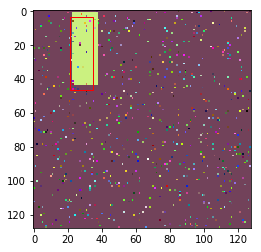

In [8]:
show_pred(5)

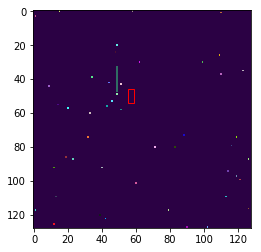

In [9]:
show_pred(9)

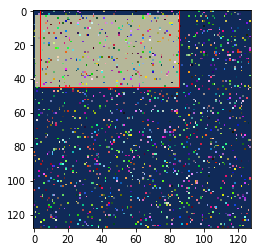

In [10]:
show_pred(54)

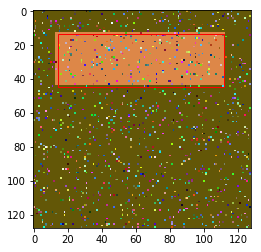

In [11]:
show_pred(91)

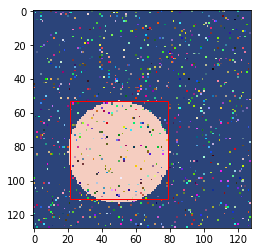

In [12]:
show_pred(280)

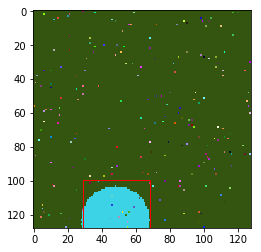

In [13]:
show_pred(303)

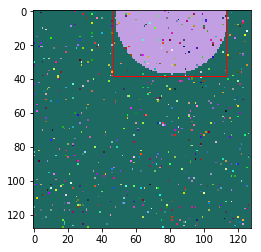

In [14]:
show_pred(330)

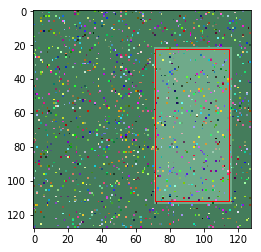

In [15]:
show_pred(36)